In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, SGDClassifier, Perceptron
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from catboost import CatBoostRegressor

import warnings

In [2]:
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 20

warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('train.csv', index_col='id')
print('Rows:', df.shape[0], '\nColumns', df.shape[1])

Rows: 30471 
Columns 291


In [4]:
X = df.drop(['price_doc', 'timestamp'], axis=1)
y = df['price_doc']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_pr

In [6]:
# class DeliteExtrimeValue(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
#     def fit(self, X, y=None):
#         self.X = X
#         self.y = y
#         return self
#     def transform(self, X, y=None):
#         df = X.copy()
#         df['full_sq'] = df['full_sq'].mask(df['full_sq'] > 500, 500)
#         df['cafe_count_2000'] = df['cafe_count_2000'].mask(df['cafe_count_2000'] > 200, np.NaN)
#         df['life_sq'] = df['life_sq'].mask(df['life_sq'] > 500, 500)
#         df['build_year'] = df['build_year'].mask(df['build_year'] < 1900, np.NaN)
#         df['build_year'] = df['build_year'].mask(df['build_year'] > 2015, np.NaN)
#         df['state'] = df['state'].mask(df['state'] > 4, np.NaN)
#         df['church_count_2000'] = df['church_count_2000'].mask(df['church_count_2000'] > 80, np.NaN)
#         return df.replace(np.NaN, 0)
        
#     def fit_transform(self, X, y=None):
#         return self.fit(X,y).transform(X, y)

In [7]:
class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)
    
class CategoricalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
#         numeric_features = []
        self.cat_features = []
        self.le_list = {}
        for column in X:
            if X_train[column].dtype == 'object':
                self.cat_features.append(column)
                self.le_list[column] = LabelEncoderExt().fit(X[column])
        return self

    def transform(self, X):
        for column in self.cat_features:
            X[column] = self.le_list[column].transform(X[column])
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
class MyStandardScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.mean = {}
        self.std = {}
        for column in X:
            self.mean[column] = X[column].mean()
            self.std[column] = X[column].std()
        return self

    def transform(self, X):
        for column in X:
            X[column] = (X[column] - self.mean[column]) / self.std[column]
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
class DeliteNanValues(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = pd.DataFrame(X)
        X.fillna(0, inplace=True)
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)
    
pipe = Pipeline(steps=[
    ('CategoricalFeatures', CategoricalFeatures()),
    ('MyStandardScaler', StandardScaler()),
    ('DeliteNanValues', DeliteNanValues()),
#     ('PCA', PCA(n_components=6))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe.fit(X_train)

Pipeline(steps=[('CategoricalFeatures', CategoricalFeatures()),
                ('MyStandardScaler', StandardScaler()),
                ('DeliteNanValues', DeliteNanValues())])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_test

id
4742     12319849
26796     6800000
6986      4650000
11310     1200000
20977     5650000
           ...   
8508      5856084
17819     5500000
1193      7700000
12196     4400000
21550     9200000
Name: price_doc, Length: 6095, dtype: int64

In [9]:
X_test

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_pr

In [10]:
def fitting(clf):
    clf.fit(pipe.transform(X_train), y_train)
    print('Train loss:', mean_squared_log_error(clf.predict(pipe.transform(X_train)), y_train))
    print('Test loss:', mean_squared_log_error(clf.predict(pipe.transform(X_test)), y_test))
fitting(CatBoostRegressor(verbose=0, iterations=100))

Train loss: 0.21613134599730868
Test loss: 0.22099950242955121


In [11]:
X_embedded = TSNE(n_components=2).fit_transform(pipe.transform(X))
X_embedded.shape

(30471, 2)

In [12]:
# df_out = pd.DataFrame(X_embedded, columns=['x', 'y'])
# g = sns.JointGrid(data=df_out, x="x", y="y")
# g.plot_joint(sns.scatterplot, size=mpg["horsepower"], sizes=(30, 120),
#              color="g", alpha=.6, legend=False)
# g.plot_marginals(sns.rugplot, height=1, color="g", alpha=.6)

In [13]:
kmeans = KMeans(n_clusters=100, random_state=0).fit(pipe.transform(X))

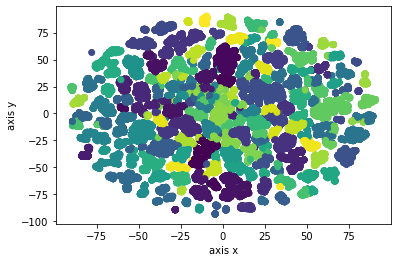

In [14]:
df_out = pd.DataFrame(X_embedded, columns=['x', 'y'])
plt.scatter('x', 'y', c=kmeans.labels_, data=df_out)
plt.xlabel('axis x')
plt.ylabel('axis y')
plt.show()

In [15]:
df['label'] = kmeans.labels_

In [16]:
df[df['label'] == 0].head(20)

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [17]:
df[df['label'] == 2]

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,c

In [18]:
conditions = [
    (df['price_doc'] <= df['price_doc'].quantile(0.1)),
    (df['price_doc'] > df['price_doc'].quantile(0.1)) & (df['price_doc'] <= df['price_doc'].quantile(0.2)),
    (df['price_doc'] > df['price_doc'].quantile(0.2)) & (df['price_doc'] <= df['price_doc'].quantile(0.3)),
    (df['price_doc'] > df['price_doc'].quantile(0.3)) & (df['price_doc'] <= df['price_doc'].quantile(0.4)),
    (df['price_doc'] > df['price_doc'].quantile(0.4)) & (df['price_doc'] <= df['price_doc'].quantile(0.5)),
    (df['price_doc'] > df['price_doc'].quantile(0.5)) & (df['price_doc'] <= df['price_doc'].quantile(0.6)),
    (df['price_doc'] > df['price_doc'].quantile(0.6)) & (df['price_doc'] <= df['price_doc'].quantile(0.7)),
    (df['price_doc'] > df['price_doc'].quantile(0.7)) & (df['price_doc'] <= df['price_doc'].quantile(0.8)),
    (df['price_doc'] > df['price_doc'].quantile(0.8)) & (df['price_doc'] <= df['price_doc'].quantile(0.9)),
    (df['price_doc'] > df['price_doc'].quantile(0.9))
    ]

values = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df['price_grade'] = np.select(conditions, values)

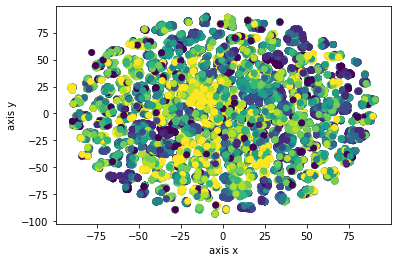

In [19]:
df_out = pd.DataFrame(X_embedded, columns=['x', 'y'])
plt.scatter('x', 'y', c=df['price_grade'], data=df_out)
plt.xlabel('axis x')
plt.ylabel('axis y')
plt.show()